In [0]:
#### MOUNT AND READ S3 FILES
####Ceci doit être fait une seule fois pour lier le répertoire AWS avec Databricks.
#AWS_BUCKET_NAME = "datasvg"
#MOUNT_NAME = "bridge"
#dbutils.fs.mount("s3a://%s" % AWS_BUCKET_NAME, "/mnt/%s" % MOUNT_NAME)
#display(dbutils.fs.ls("/mnt/%s" % MOUNT_NAME))

#En cas de soucis d'abord faire 'unmount' et faire après 'mount' de nouveau.
###dbutils.fs.unmount("/mnt/bridge")

path,name,size,modificationTime
dbfs:/mnt/bridge/Test/,Test/,0,1672222772641
dbfs:/mnt/bridge/Train/,Train/,0,1672222772641
dbfs:/mnt/bridge/Validation/,Validation/,0,1672222772641


In [0]:
#A. Import des librairies.

import pandas as pd
import numpy as np
import io
import os
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt

In [0]:
#---------------------
#B. Création des "Paths" pour simplifier la tâche.
#ATTENTION: On ne cherche pas à entraîner un modèle pour le moment, on va donc travailler pour l'instant uniquement avec la dossier 'TEST'.

PATH = '/mnt/bridge'
PATH_Data = PATH+'/Test'
PATH_Result = PATH+'/Results'
PATH_Result_PCA = PATH+'/Results_PCA'
PATH_Result_csv= PATH+'/Results_csv'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

PATH:        /mnt/bridge
PATH_Data:   /mnt/bridge/Test
PATH_Result: /mnt/bridge/Results


In [0]:
#---------------------
#C. Création de la Session Spark et du Context nécessaires pour l'utilisation de Spark.
spark = (SparkSession
             .builder
             .appName('P8')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

In [0]:
sc = spark.sparkContext

In [0]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.1 
 Master 
 spark://10.75.169.37:7077 
 AppName 
 Databricks Shell

In [0]:
#---------------------
#D. Le modèle.
#Le modèle choisit 'MobileNetV2' de TensorFlow (avec les poids pré-calculés issus d'imagenet), pour sa rapidité et efficacité.
model = MobileNetV2(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

14536120/14536120 [==============================] - 0s 0us/step


In [0]:
#On enlève la Deuxième couche du modèle, non utile pour nous.
#En fait, on veut juste récupérer le vecteur de caractéristiques de dimensions (1,1,1280) qui servira, plus tard, au travers d'un moteur de classification à reconnaître 
#les différents fruits du jeu de données.
new_model = Model(inputs=model.input, outputs=model.layers[-2].output)

In [0]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [0]:
#broadcast des poids du modèle pour rendre le processus plus rapide (en distribuant le poids du modèle à tous les workers, qui sont avec spark des cœur de processeur 
#indépendants).
brodcast_weights = sc.broadcast(new_model.get_weights())

In [0]:
#On crée un fonction qui enlève la deuxième couche du modèle et broadcast (distribue) les poids aux différents workers. (Ceci sera plus simple à réutiliser).
def model_fn():
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

In [0]:
#---------------------
#E. Chargement des données (ie. des images).
#ATTENTION: On ne cherche pas à entraîner un modèle pour le moment, on va donc travailler pour l'instant uniquement avec le dossier 'TEST'.
#ATTENTION: On travaillera avec une base de données très réduite. On prendra en fait que 3 images par fruits pour le dossier 'TEST' car on a choisi de réduire le dataset utilisé afin de ne pas dépasser les version moins chères de AWS, et être en ligne avec la version test de Databricks.

#On charge les images en format binaire -> ceci est particulièrement utile dans le traitement d'images car ce format permet de séparer facilement un objet de l'arrière-plan. En gros, le processus de segmentation permet d'étiqueter chaque pixel comme "arrière-plan" ou "objet".
#On spécifie que l'on veut charger uniquement les images (.jpg).
#On spécifie que l'on veut charger tous les objets possibles contenus dans les sous-dossiers du dossier (rappelons que l'on a 24 sous dossiers)-> 'recursiveFileLookup' est utilisé pour charger des fichiers de manière récursive.


images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

In [0]:
#Liston les premières 5 images (tout type de fruits confondus). 
#On fait ceci juste pour vérifier que les images ce sont bien chargées.

images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+------------------------------------------------+---------------+
|path                                            |label          |
+------------------------------------------------+---------------+
|dbfs:/mnt/bridge/Test/apple_hit_1/r0_167.jpg    |apple_hit_1    |
|dbfs:/mnt/bridge/Test/apple_hit_1/r1_51.jpg     |apple_hit_1    |
|dbfs:/mnt/bridge/Test/cabbage_white_1/r0_139.jpg|cabbage_white_1|
|dbfs:/mnt/bridge/Test/cabbage_white_1/r0_71.jpg |cabbage_white_1|
|dbfs:/mnt/bridge/Test/cabbage_white_1/r0_103.jpg|cabbage_white_1|
+------------------------------------------------+---------------+
only showing top 5 rows

None


In [0]:
#---------------------
#F. Fonctions auxiliaires.

#F.1 Traitement des images (size et array).
#Note: 'Parsing'-> changer le format.
#On redimensionne les images à (224,224) pour que ce soit en ligne avec les besoins de notre modèle.
#Une fois les images redimensionnées, on crée un array avec elles, et avec 'preprocess_input' on pré-traite cet array de sorte à convertir les images de RVB à BGR. Chaque canal de couleur est ainsi centré sur zéro par rapport au jeu de données ImageNet, sans mise à l'échelle, et on obtient un résultat compatible avec TensorFlow.

def preprocess(content):
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)


In [0]:
#F.2 Featurize d'une série pandas d'images, en utilisant un modèle. 
#En retour on obtient une série pandas des features des images.
#En gros, on prédit avec notre modèle pour l'obtention des features.
#Pour certaines couches (layers) du modèle les features peuvent être des tenseur multi-dimensionnels, on utilise 'flatten', pour aplatir ces tenseurs; c'est à dire, pour supprimer toutes leurs dimensions sauf une.

def featurize_series(model, content_series):
    
    input = np.stack(content_series.map(preprocess)) #on stack (ajoute des arries) et applique la focntion process définie auparavant.
    preds = model.predict(input) #on predit avec le modèle choisi.
    
    output = [p.flatten() for p in preds] #on applatit les tenseur.
    return pd.Series(output)


In [0]:
#F.3 Pandas UDF (batches et définition du modèle).
#Avec le 'Scalar Iterator pandas UDFs' on peut loader le modèle une fois et le réutiliser pour plusieurs 'bacthes' (lots) de données. Cela amortit le coût en temps et mémoire quand on a de gros modèles.
#En retour on a une colonne 'Spark DataFram' de type ArrayType(FloatType).
#Le modèle choisi est le résultat de la fonction model_fn(), c'est à dire MobileNetV2 sans la deuxième couche et avec les poids broadcastés (distribués)
#Le paramètre 'content_series_iter' est un itérateur sur des 'batches' (lots) de data, où chaque 'batch' lot est un 'pandas Series' d'images. Grace à ces batches et au modèle aux poids broadcastés considérés ici on parle de 'Distributed model inference using TensorFlow Keras'.

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    model = model_fn() 
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/databricks/spark/python/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [0]:
#---------------------
#G. Calculs: Extraction des features sur nos images.
#Note: '.repartition()'-> crée en quelque sorte des 'bacthes' (des lots) d'images, ici on en crée 24 -> on aura donc 24 fichier parquet à la fin. Le nombre de est lots choisit car on a 24 types de fruits (ie. 24 dossiers).

features_df = images.repartition(24).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

In [0]:
#---------------------
#H. Vérifications de nos résultats.
#H.1 Conversion de PySpark DataFrame a Pandas (DataFrame).
f_pandas=features_df.toPandas()

In [0]:
#H.2 Identification du nombre de features par ligne avant PCA -> Notez qu'on a bien le 1280 attendues.
f_pandas.loc[0,'features'].shape

Out[19]: (1280,)

In [0]:
#H.3 Shape générale de notre data frame de résultats.
#On retrouve bien nos 72 images (3 par fruits car on a choisi de  réduire le dataset utilisé afin de ne pas dépasser les version moins chères de AWS, et être en ligne avec la version test de Databricks).
f_pandas.shape

Out[20]: (72, 3)

In [0]:
f_pandas.dtypes

Out[21]: path        object
label       object
features    object
dtype: object

In [0]:
#---------------------
#I. PCA -> Réduction de dimension des feature vectors.
#On utilise le réduction de dimension de type PCA en PySpark, pour laquelle on fixe nombre de features (ie. k) de sorte à avoir aux alentours de 95% de la variance expliquée.
#Pour pouvoir appliquer le PCA à notre colonne features, il faut que celle-ci soit de type: 'VectorUDT' et non 'ArrayType'. Il faut donc faire quelques réglages.

features_df2=features_df

In [0]:
#I.1 Transformation de 'ArrayType' à 'VectorUDT'.
#Avec col("*") on sélectionne toutes les colonnes, pour les voir toutes apparaître sur features_df2.

list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
features_df2 = features_df2.select(col("*"),  list_to_vector_udf(features_df2["features"]).alias("features_2"))

[0.16717410755495418,0.10695082076009632,0.08937529847603166,0.06656310502117976,0.059235185994866005,0.04258826230614675,0.038831054452298536,0.03617731764026572,0.030306836207042304,0.025453077766794806,0.021515975441147504,0.018862227546923085,0.01763736779647802,0.016899779978316896,0.016191085595402534,0.013537974777302342,0.012388647002692404,0.01215974453617492,0.011204039450845919,0.010252310465504141,0.009734365261742367,0.009248883619660963,0.008981470644071024,0.008336364800867207,0.007919384871342328,0.0070792519465446065,0.006808740711867251,0.006478054561197211,0.006357789023240068,0.006123685280492429,0.005641743755083581,0.005572141252293842,0.005218421491224238,0.004677184504714962,0.004484540759437139,0.004335319296989927,0.004272456507065597,0.003922594074681806,0.003826079970918324,0.003741434270546693,0.003560210535390303,0.0034870501910203022,0.0034482958070240688,0.003227008553529712,0.0031598976608519036,0.0030362645320604737,0.0029311707860455545,0.002871261080

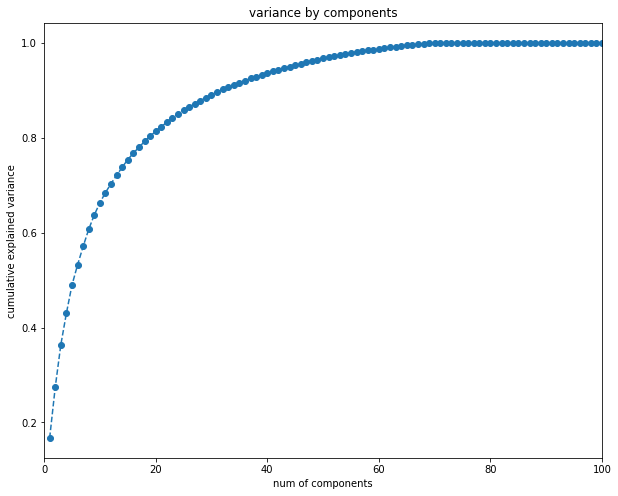

In [0]:
#I.2 Choix du nombre de Features auquel on veut réduire (ie. choix de 'k').
#On cherche a avoir un nombre de features qui explique aux alentours de 95% de la variance.
#D'après le graphique obtenue 50 features serait un nombre convenable (ie.k=50).

pca1 = PCA(k=1280, inputCol="features_2", outputCol="pcaFeatures") #Je prendre mon nombre maximum de features.
pcaModel = pca1.fit(features_df2) 
print(pcaModel.explainedVariance) #On explique les variances.
cumValues = pcaModel.explainedVariance.cumsum() #on a les valeurs cumulées.
# plot the graph 
plt.figure(figsize=(10,8))
plt.plot(range(1,1281), cumValues, marker = 'o', linestyle='--')
plt.title('variance by components')
plt.xlabel('num of components')
plt.ylabel('cumulative explained variance')
plt.xlim(0, 100)

In [0]:
#I.2 PCA en PySpark.
pca = PCA(k=50, inputCol="features_2", outputCol="pcaFeatures")
model_pca = pca.fit(features_df2)

result = model_pca.transform(features_df2)

In [0]:
display(result)

path label features features_2 pcaFeatures dbfs:/mnt/bridge/Test/cucumber_3/r0_263.jpg cucumber_3 List(0.7467964, 0.24758677, 0.037695806, 0.0, 0.022981547, 0.0, 0.6246672, 0.08768839, 0.0, 0.0, 0.0, 0.034959637, 0.54815024, 0.005171951, 0.22802594, 0.0, 0.0, 0.0, 0.22183959, 0.0, 0.0, 0.0, 0.0, 4.7689554E-4, 0.0, 0.0, 0.4092078, 0.010921848, 0.011280615, 0.25318772, 0.042626586, 0.08381158, 0.20385912, 3.463783, 0.0, 1.0528544, 0.9151017, 0.19691443, 0.0, 0.017494407, 0.0, 0.0, 0.06676468, 0.72250754, 0.0, 0.0, 0.038708795, 0.0, 2.1095269, 0.0, 0.16640379, 0.0, 0.028070275, 0.0, 0.0, 1.2473098, 0.0, 2.3925865, 0.0051288703, 0.0, 0.069179505, 0.20034099, 0.0, 0.0, 0.8382629, 1.3412993, 0.17871635, 0.0, 0.0, 0.014583753, 0.0, 0.14707598, 0.02701807, 1.6340575, 0.9987402, 1.5417119, 0.026889626, 0.0388299, 0.0, 0.36764207, 0.008990113, 0.003137608, 0.0, 0.0, 0.020816501, 0.0, 0.0, 0.0, 0.012144653, 0.0, 0.0, 0.0, 0.47678122, 0.14642332, 0.041624527, 0.1245075, 0.014570888, 1.0366418, 0.18235238, 0.08593512, 0.0, 0.0, 0.5816627, 0.0, 0.0, 0.0, 0.0, 0.0063181897, 0.06562898, 0.0, 0.010076921, 0.11120846, 0.0025985094, 0.9785046, 0.0, 0.009650493, 0.2491179, 0.0, 0.20562616, 0.0, 0.94823575, 0.02131651, 0.0, 0.57403016, 0.14569382, 0.7609907, 3.0199606, 3.1664405, 0.20236671, 1.228527, 0.18450846, 0.14175633, 0.17499436, 0.0, 0.0, 0.0, 0.0, 0.018701475, 0.011357511, 0.0, 0.5060348, 0.0, 0.04362329, 0.010178041, 0.0, 0.0, 0.26498038, 0.46400854, 0.1529573, 0.5638478, 0.26134747, 0.0, 0.0, 0.0, 0.0, 1.0314845, 0.024028096, 0.19624546, 1.4917974, 0.0080018435, 0.018650493, 0.031749714, 0.0, 1.5557543E-4, 0.35500515, 0.0, 1.3119578, 0.17265709, 0.84352535, 0.0, 0.048929643, 0.890831, 0.21332896, 0.0, 0.015407212, 1.218077, 1.4300582, 0.0, 0.07184951, 0.121158496, 3.6162045, 0.0, 2.3826125, 0.008515932, 0.0, 0.5320756, 0.0, 2.0954776, 0.0, 0.0, 0.0, 0.9821465, 0.18716824, 0.14927942, 0.0, 0.0, 0.0, 0.0, 0.009789458, 0.42914712, 0.0, 0.13783339, 0.0, 0.5471393, 0.4590548, 0.0, 0.016145492, 0.4808243, 0.023815855, 0.0091260895, 0.09342622, 0.0, 0.35021606, 0.0, 0.03270883, 0.59980613, 0.0, 0.0010660327, 0.0, 0.11192754, 0.54452634, 0.0563343, 0.0, 0.92656326, 0.0, 0.0, 0.0, 0.50300014, 0.14490879, 0.41304573, 1.1011678, 0.0, 0.0, 0.2683434, 0.105509944, 0.96882784, 0.05188878, 0.0, 0.0, 0.07134085, 1.0181284, 0.05737341, 0.16337033, 0.0, 0.01850024, 0.91995144, 0.46233878, 0.0, 0.03258354, 0.5117205, 0.8684669, 0.0, 0.17062192, 0.0, 0.5807342, 3.0899422, 1.2579136, 1.1118249, 0.46983516, 0.021296248, 0.0, 0.28379825, 1.3615422, 0.060036425, 0.106342785, 0.0, 0.01539567, 0.0, 0.0, 0.020413224, 0.011155936, 0.0, 0.0, 0.0, 0.45420188, 0.13581201, 0.0, 0.0, 0.05248744, 0.4046019, 0.0, 0.072790526, 1.1134566, 0.0, 1.0927271, 0.0, 0.9385987, 0.030181037, 0.041028637, 0.16774182, 0.07937516, 0.04867552, 0.0, 0.082138926, 0.0, 0.4167815, 0.012890514, 0.34483206, 0.20971735, 0.17176251, 0.40950036, 0.2902882, 0.0, 0.0, 1.3800253, 1.6936429, 0.0, 0.0, 0.018785583, 0.75369483, 1.0220022, 0.4311905, 0.03942436, 0.064284705, 0.0015020468, 0.0, 0.0, 0.0, 0.0, 0.24016578, 0.011891531, 0.0, 1.1163627, 0.46049273, 0.0, 0.0, 0.0, 0.02696956, 0.0, 0.059913043, 0.0, 0.0, 2.84941, 0.19838475, 0.0, 0.005180417, 0.034533918, 1.0511101, 0.0, 0.5336426, 0.0, 0.0, 0.15266249, 0.15758808, 0.0, 0.13525316, 0.035217363, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3633678, 0.0, 0.0063601807, 0.0, 0.56987154, 0.0, 0.18086492, 0.0, 0.18909198, 0.5114649, 1.3127487, 0.19572094, 0.0, 0.03891066, 0.24381252, 0.0, 0.43483546, 0.0, 0.012886602, 0.0, 0.0, 0.42864913, 0.027211247, 0.3031233, 0.1188611, 0.106760345, 0.0, 0.42962545, 0.12611268, 0.0, 0.7269938, 0.18311827, 0.005631145, 0.29872122, 0.0, 0.06869298, 0.35845184, 2.0260527, 0.0033614782, 0.28424603, 0.0, 0.008179645, 0.0, 0.0, 1.5142542, 0.0, 0.2785397, 0.7056153, 0.8682723, 0.3721502, 0.0, 0.02033364, 0.017255949, 0.06525096, 5.6112057E-4, 0.72652644, 0.001155756, 2.3458498, 2.8608315, 0.06947957, 0.010286954, 0.011565977, 0.3

In [0]:
#---------------------
#J. Vérifications de nos résultats suite au PCA.
#J.1 Conversion de PySpark DataFrame a Pandas (DataFrame).
f_pandas_PCA=result.toPandas()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:119: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field features_2. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


In [0]:
#J.2 Identification du nombre de features par ligne après PCA -> Notez qu'on a bien le 50 attendues.
f_pandas_PCA.loc[0,'pcaFeatures'].shape

Out[157]: (50,)

In [0]:
#J.3 Shape générale de notre data frame de résultats.
#On retrouve bien nos 72 images (3 par fruits car on a choisi de  réduire le dataset utilisé afin de ne pas dépasser les version moins chères de AWS, et être en ligne avec la version test de Databricks).
f_pandas_PCA.shape

Out[159]: (72, 5)

In [0]:
#---------------------
print(PATH_Result)

/mnt/bridge/Results


In [0]:
print(PATH_Result_PCA)

/mnt/bridge/Results_PCA


In [0]:
#---------------------
#K. Enregistrement de nos features obtenus en format 'parquet' sur S3.
#'Apache Parquet' est un format de fichier conçu pour stocker de très gros volumes de données ayant une structure « complexe ». Il est particulièrement efficace pour l’analyse de données car il facilite la distribution de la charge de traitement, et sa structuration permet d’exclure rapidement des pans entiers du jeu de données, et donc de réduire d’autant le temps de traitement.
#Note: dans nos dossiers respectifs, 'Results' et 'Results_PCA', on retrouvera 24 fichiers au format parquet. En fait on rappelle que l'on a décidé de regrouper les images en 24 'batches' (ie. lots d'images) pour accélérer le processus; on a donc un fichier par lot. 

#K.1 Résultats avant PCA.
features_df.write.mode("overwrite").parquet(PATH_Result)

In [0]:
#K.2 Résultats après PCA.
result.write.mode("overwrite").parquet(PATH_Result_PCA)

In [0]:
#--------------------------------------------------------------------------------------------------------------------------------------------------------

In [0]:
#L. Lecture des fichiers 'parquet' obtenus et sauvegardées en S3.
#Note: Avec 'spark.read.parquet', en pointant sur le répertoire principal (dans notre cas 'Results'), nous chargerons tous les fichiers du répertoire de type parquet.

df = spark.read.parquet(PATH_Result, engine='pyarrow')

In [0]:
display(df)

path label features dbfs:/mnt/bridge/Test/apple_granny_smith_1/r1_251.jpg apple_granny_smith_1 List(0.78509045, 0.94276524, 0.0, 0.0, 0.0, 0.18496965, 0.0, 0.0694279, 0.103255376, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03737079, 0.0, 0.0, 0.09759391, 0.0, 0.0, 0.22270946, 0.050179053, 0.0, 0.0, 0.52550423, 1.2778711, 0.0, 0.0, 0.5197245, 0.0020650844, 0.0, 0.0, 0.44645616, 0.0, 0.13031834, 0.14059882, 2.1999779, 0.0, 0.0, 0.047193915, 0.0, 0.0, 1.5839534, 0.0, 0.0, 0.4349056, 0.23649508, 0.6606921, 0.0, 0.015158449, 2.4021888E-4, 0.0, 0.0, 0.0, 0.1891966, 0.0, 0.031277373, 0.0, 0.02731763, 0.0, 0.0, 0.0, 0.0, 0.3602988, 0.06701653, 0.124102786, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11493514, 0.3177375, 0.0, 0.0, 0.11075862, 0.039396074, 0.1271352, 0.0, 0.2318707, 0.12300039, 0.0, 0.0, 0.4530867, 0.0, 0.0, 0.013674882, 0.18436135, 0.021185292, 0.49742788, 0.30888566, 0.0, 0.014879548, 0.014159601, 0.0, 0.0, 0.01825428, 0.0, 0.11093818, 0.030685054, 0.0, 0.0, 0.0, 0.24906303, 0.0, 0.05254539, 0.46216077, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5219911, 0.4029344, 0.37790892, 0.05581674, 0.0, 0.8990466, 0.06701407, 0.0, 0.043013874, 0.0, 0.0, 0.014564047, 0.8554583, 1.7824978, 1.1764632, 0.041574, 0.873494, 0.025512764, 1.728216, 0.0, 0.0, 0.6779025, 0.0, 0.0, 0.0, 0.008060757, 0.0, 0.30171508, 0.0, 0.39968595, 0.0, 0.0, 0.09867729, 0.0, 0.22093111, 0.14398846, 0.121683896, 1.0664473, 0.0, 0.0, 0.0, 0.0, 0.0, 0.022350632, 0.0, 0.18544485, 0.0, 0.0, 0.0, 0.0, 0.021048974, 0.0, 1.0111657, 0.0013882578, 0.0, 0.0, 0.0, 0.295753, 0.03148945, 0.009716268, 0.14988767, 0.0, 0.1064011, 0.16542466, 0.0026575108, 0.18984891, 0.33141077, 0.8916051, 0.0, 1.5902236, 0.0, 1.9386555, 0.64194643, 0.7045483, 3.086711, 0.0, 0.18950544, 0.113774136, 0.9609019, 0.0, 1.10419, 0.0, 0.0, 0.0, 0.0, 0.10291452, 0.21224488, 0.0, 0.1721387, 0.0, 0.61411047, 0.005256458, 0.13151911, 0.0, 0.024563566, 0.0, 0.09999094, 0.0, 0.01487913, 0.0, 0.039702825, 0.0, 2.5486636, 0.15248057, 3.4270968E-4, 0.0, 0.0, 0.09925471, 0.00967198, 0.0, 0.4854734, 0.22954758, 0.0, 0.4998236, 0.010811689, 0.15702808, 0.0, 0.43592492, 1.1365924, 0.35018682, 0.1593108, 0.0, 0.012777523, 0.41730827, 0.011067147, 0.40958393, 0.23241284, 0.53861827, 0.0, 0.0, 0.0, 0.6691442, 0.15386704, 0.026994023, 0.0, 0.058595844, 0.6663007, 0.85861504, 0.19572599, 0.0, 0.097710066, 0.50899917, 1.0341005, 0.26966166, 0.08030292, 0.0, 0.22934788, 0.0, 0.027220288, 0.0, 0.013693138, 0.012424732, 0.028081523, 0.0, 0.0, 0.0, 0.04930611, 0.0, 0.0, 0.0, 0.0, 0.0047709895, 0.003970876, 0.0, 0.32781854, 0.24476406, 0.0, 0.0, 0.07072055, 0.057666972, 0.2117602, 1.0017258, 4.1494565E-4, 0.030460007, 0.0, 0.0, 0.0, 0.0, 0.03529906, 0.0, 0.06747424, 0.0, 0.27168792, 0.0, 0.0, 0.0, 0.0, 0.6935061, 0.0, 0.0, 0.0, 0.023933109, 0.113820896, 0.0, 0.0, 0.0053388146, 0.0, 1.7341554, 0.025071153, 0.0, 0.04494116, 0.15089, 0.0, 0.0, 0.0, 0.0, 0.0030190994, 0.030876802, 1.2061967, 0.9429692, 0.0, 0.0, 0.4038324, 0.0, 0.0, 0.0, 0.00797081, 0.0, 0.057486232, 0.031147188, 0.0, 0.0, 0.0, 0.33730668, 0.010031204, 0.0026243269, 0.764136, 0.0, 0.0, 0.0, 0.0064826985, 0.33589524, 2.350165, 0.0, 0.0, 0.0, 0.0, 0.026280548, 0.0, 0.0, 2.6251788, 0.0, 0.0, 0.0, 0.20434617, 0.023170792, 0.0, 0.0, 0.5189698, 0.0, 0.24443151, 0.24694006, 0.13001163, 0.98426586, 0.27200848, 0.0, 0.0, 0.059645254, 0.02122011, 0.0, 0.21294598, 0.015940199, 0.0010419767, 0.01828979, 0.625846, 0.002139763, 0.0, 0.0, 0.0, 4.7975656E-4, 1.4340668, 0.0, 0.0, 0.0, 0.0, 0.9176902, 0.07198001, 0.017177766, 0.0, 0.0, 0.0, 0.015772654, 0.030054307, 8.66092E-5, 0.6780848, 0.0, 0.0022158234, 0.64614445, 0.04635185, 0.28819412, 0.0, 0.08620797, 0.21612129, 0.0045274035, 0.0, 0.49122542, 0.44271448, 0.21390228, 3.233855, 0.248784, 0.0, 0.2388947, 0.0, 0.0, 2.7274625, 0.3419891, 0.55331033, 0.0, 0.94311464, 0.03064538, 0.0, 1.6611485, 0.03419085, 2.1853569, 0.16158643, 0.0, 0.0, 0.16936362, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20088124, 0.038396202, 0.0, 0.0, 0.0, 0.6762362, 4.3162537, 2.0150504, 0.0024840005, 